# Logistic Regression On Amazon Fine Food Reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


### Objective
* To classify the positive and negative reviews.

###  How to classify?
* By applying vectorization techniques such as BOW, TF-IDF ,Avg W2V , Tf-Idf weighted W2V.
* Applying Logistic regression on above vectors. 
* Column used to check the Acuracy will be Score.
  - Positive review (rating 4-5)
  - Negative review (rating 1-2)

## Loading Data

In [1]:
%matplotlib inline
import warnings as wr
wr.filterwarnings('ignore')

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

con = sqlite3.connect('database.sqlite') #building connnection with database
review_data = pd.read_sql_query('''select * from Reviews where Score != 3''',con)#importing data from database

#function to replace rating with 1(+ve) or 0(-ve)
def Replace_rate(x):
    if x < 3:
        return 0
    else:
        return 1

OldScore = review_data['Score']
NewScore = OldScore.map(Replace_rate)
review_data['Score'] = NewScore
print('Review data is loaded with {0} rows and {1} columns'.format(review_data.shape[0],review_data.shape[1]))
review_data.head()



Review data is loaded with 525814 rows and 10 columns


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Data Preprocessing

### Removing duplicate data

In [2]:
#Checking for duplicate data 
duplicate_data = pd.read_sql_query('''select UserId, ProductId, ProfileName, Time, Score, Text, count(*) as count from Reviews where 
Score != 3 group by UserId having count(*) > 1 ''',con)

duplicate_data.shape

(75346, 7)

In [3]:
#removing duplicate data
print('Data before de-duplication had {} rows and {} columns'.format(review_data.shape[0],review_data.shape[1]))
review_data = review_data.sort_values('ProductId',axis = 0, ascending=True, inplace=False, kind='quicksort', na_position='last')

review_data = review_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print('Data after de-duplication had {} rows and {} columns'.format(review_data.shape[0],review_data.shape[1]))

Data before de-duplication had 525814 rows and 10 columns
Data after de-duplication had 364173 rows and 10 columns


In [4]:
# Helpfulness denominator should be always greater than numerator
review_data = review_data[review_data.HelpfulnessNumerator <= review_data.HelpfulnessDenominator]
review_data.shape

(364171, 10)

### Cleaning the data
* Removing html tags
* Removing stopwords
* Converting words to lower case
* Removing alphanumeric value 
* Lemmitizing the data

In [7]:
import re
import os
import nltk
import string
from tqdm import tqdm
from nltk.corpus import stopwords 

sno = nltk.stem.SnowballStemmer('english')#initialise stemmer
stop = set(stopwords.words('english'))

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


if not os.path.isfile('final.sqlite'):
    final_string = []
    for i, sent in enumerate(tqdm(review_data['Text'].values)):
        filtered_sentence=[]
        sent = cleanhtml(sent)
        for w in sent.split():
            for cleanwords in cleanpunc(w).split():
                #we are spliting the data two time because after first splitting there may be a possibility that we can get a word
                # 'abc.def' which after the second split will become two words 'abc' 'def'
                if((cleanwords.isalpha()) and (len(cleanwords)>2)): # there is no adjective with length 2
                    if(cleanwords.lower() not in stop):
                        s=(sno.stem(cleanwords.lower())).encode('utf8')
                        filtered_sentence.append(s)
        str1 = b" ".join(filtered_sentence)
        final_string.append(str1)
        

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [05:42<00:00, 1062.13it/s]


In [8]:
#storing the data in a database(.sqlite file)
review_data['CleanedText'] = final_string
review_data['CleanedText']=review_data['CleanedText'].str.decode("utf-8")
conn = sqlite3.connect('final.sqlite')
c = conn.cursor()
conn.text_factory = str
review_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
conn.close()

In [9]:
#importing preprocessed data into a new dataframe
conn = sqlite3.connect('final.sqlite')
preprocessed_data = pd.read_sql_query('''select * from Reviews limit 100000''',conn)
print(preprocessed_data.shape)
preprocessed_data.head()

(100000, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [10]:
#https://www.programiz.com/python-programming/datetime/strftime
#converting given time with format %m/%d/%Y, %H:%M:%S
from datetime import datetime

timestamp = preprocessed_data['Time']
time_data=[]
for i in timestamp:
    date_time = datetime.fromtimestamp(i)
    d = date_time.strftime("%m/%d/%Y, %H:%M:%S")
    time_data.append(d)

preprocessed_data['Time'] = time_data

In [11]:
#sorting values according to time
processed_data = preprocessed_data.sort_values('Time',axis=0).reset_index(drop=True)
processed_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,516061,557949,B0000DJDL4,A1Y20KNCR0SZA1,"Dessartfamily ""grandmasoven""",8,9,1,"01/01/2004, 05:30:00",The best Kringles ever,Others try to make kringles but there is only ...,other tri make kringl one bakeri make real dan...
1,77542,84346,B0000DGF5S,AQDTYG93O2WYO,Paul L. Bardzik,15,16,0,"01/01/2006, 05:30:00",Broken pot,"Not sure if the plant is going to survive, The...",sure plant go surviv pot broken open box yet s...
2,309826,335493,B0002HVDNY,A3FVAWZNKW9GX,"A.Trendl HungarianBookstore.com ""What should ...",1,2,1,"01/01/2006, 05:30:00",Slowly Smoked Pork is Delicious,I buy Karaj Hungarian Pork Loin regularly at o...,buy karaj hungarian pork loin regular local hu...
3,242022,262487,B0007KLGC4,A2RV24L38GOIGT,Mark L. White,8,9,1,"01/01/2006, 05:30:00",best candy,Mallo Cup candy is the best candy that has eve...,mallo cup candi best candi ever made put marke...
4,208995,226507,B000A3I3BA,A7GXT5V1VL5UT,"J. Leigh ""jleigh7""",74,75,1,"01/01/2006, 05:30:00",Major time and effort saver,REMEMBER THE OLD WAY OF STIRRING PEANUT BUTTER...,rememb old way stir peanut butter think youv e...


### Splitting Data Based on Time

In [12]:
#splitting the data into train and test set
import math
%matplotlib inline
import warnings as wr
wr.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

X = processed_data['CleanedText']
Y = processed_data['Score']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)

### Hyperparameter tuning using gridsearch

In [13]:
# this function is defined to reduce the coding effort to find k value for each vectorization technique
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
import math
def optimal_val(x,y):
    
    a = [.00001,.0001,.001,.01,1,10,100,1000,10000]
    param = [math.log(i) for i in a]
    tscv = TimeSeriesSplit(n_splits=10)
    parameters = {'C': a}
    clf = GridSearchCV(LogisticRegression(), parameters, cv=tscv, scoring='roc_auc')
    clf.fit(x, y)
    
    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']
    
    print('Best tunned parameter is',clf.best_params_)
    print('Train data accuracy is %f%% '%(clf.best_score_*100))
    
    plt.plot(param, train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(param,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
    
    plt.plot(param, cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(param,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    plt.legend()
    plt.xlabel("C: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    return clf.best_params_

## BOW

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

count_vect = CountVectorizer()
x_train_bow = count_vect.fit_transform(x_train)
x_train_bow = preprocessing.normalize(x_train_bow)
x_test_bow = count_vect.transform(x_test)
print(x_train_bow.shape)
print(x_test_bow.shape)

(67000, 30856)
(33000, 30856)


Best tunned parameter is {'C': 10}
Train data accuracy is 93.518160% 


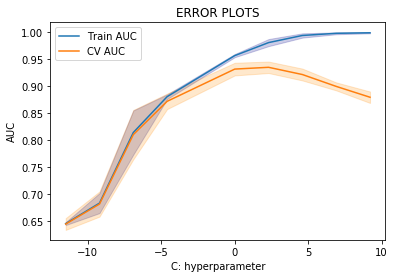

In [15]:
c = optimal_val(x=x_train_bow,y=y_train)

### Testing C on test data using L1 regularizer

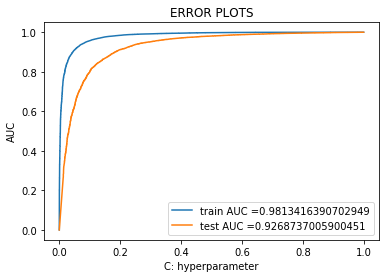

In [16]:
from sklearn.metrics import roc_curve, auc
lr_model_l1 = LogisticRegression(C=c['C'] , penalty = 'l1')
lr_model_l1.fit(x_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_model_l1.predict_proba(x_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_model_l1.predict_proba(x_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Testing C on test data using L2 regularizer

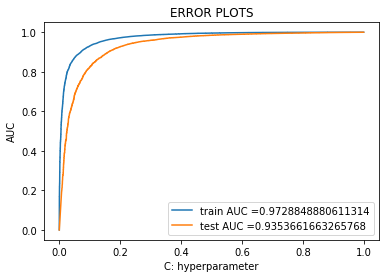

In [17]:
from sklearn.metrics import roc_curve, auc
lr_model_l2 = LogisticRegression(C=c['C'] , penalty = 'l2')
lr_model_l2.fit(x_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_model_l2.predict_proba(x_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_model_l2.predict_proba(x_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix For Train Data

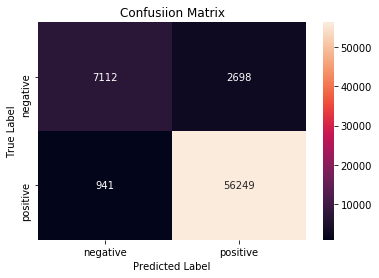

In [18]:
# predict the response
y_pred_bow = lr_model_l2.predict(x_train_bow)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [19]:
print(classification_report(y_train ,y_pred_bow))

             precision    recall  f1-score   support

          0       0.88      0.72      0.80      9810
          1       0.95      0.98      0.97     57190

avg / total       0.94      0.95      0.94     67000



### Confusion Matrix on Test Data

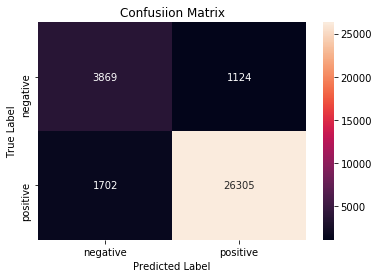

In [20]:
# predict the response
y_pred_bow = lr_model_l2.predict(x_test_bow)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [21]:
print(classification_report(y_test ,y_pred_bow))

             precision    recall  f1-score   support

          0       0.69      0.77      0.73      4993
          1       0.96      0.94      0.95     28007

avg / total       0.92      0.91      0.92     33000



## Top 10 Positive and Negative Features

In [22]:
# https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def important_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\tNegative\t\t\t\t\tPositive")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
important_features(count_vect,lr_model_l2)

		Negative					Positive
	-14.8627	worst          				9.2818	uniqu          
	-12.0887	aw             				9.2491	delici         
	-10.7524	wors           				9.1605	awesom         
	-9.9413	terribl        				9.1100	addict         
	-9.7229	tasteless      				8.7769	amaz           
	-9.1231	threw          				8.7715	perfect        
	-9.1224	disappoint     				8.4329	best           
	-9.0481	bland          				8.3256	yummi          
	-9.0208	cancel         				7.9298	excel          
	-8.7953	unfortun       				7.5536	skeptic        


### Pertubation Test on BOW

In [23]:
#Weights before adding random noise
w = lr_model_l2.coef_[0]
# adding small value to eliminate zero by division error
w = w + .000001
print(w[:30])

[ 9.00917208e-03  5.24419863e-02 -3.38076863e-02  4.90840396e-03
  5.99587012e-03  4.97934085e-02  4.48843358e-02  1.05115919e-01
  1.98496113e-02  3.89428401e-02  7.92778638e-02  1.47977117e-03
  7.68356435e-03  4.84900623e-03 -5.70479951e-01  1.05243091e-03
  3.49036735e-02 -1.98988474e-01  1.90432030e-01  1.97139300e-01
  1.39922364e-02  9.72586712e-02  1.24418076e-02 -4.87162300e-02
  7.97003340e-01  3.84022890e-03 -4.13160334e-01  1.94626725e-01
 -1.87312594e+00  3.94446492e-01]


In [24]:
#adding random noise to train data
from scipy.sparse import find
import copy
x_train_per = copy.deepcopy(x_train_bow)
noise = np.random.uniform(low=-0.0001, high=0.0001,size=(find(x_train_per)[0].size))

i,j,v = find(x_train_per)
x_train_per[i,j] = noise + x_train_per[i,j]

In [25]:
#fitting model on new data set
lr_model_per = LogisticRegression(C=.01, penalty = 'l2')
lr_model_per.fit(x_train_per,y_train)
w1 = lr_model_per.coef_[0]
w1 = w1 + .000001
print(w1[:30])

[ 1.27991567e-04  1.68177302e-04 -2.37423661e-04  1.93319518e-04
  2.26679021e-04  9.71175254e-05  5.02831160e-05  3.70064481e-04
  1.57667382e-04  6.50642198e-05  1.53980558e-04  2.52770110e-04
  1.53770353e-04  1.01021227e-04 -8.02816111e-04  1.51012134e-04
  3.11616752e-04 -6.26833083e-04  9.45373268e-05  3.05077294e-04
  2.55172218e-04  1.92659398e-04  9.65787977e-05 -4.58232793e-04
  2.99719318e-04  1.93829757e-04 -4.08997559e-05  9.39180300e-05
 -1.97639216e-03  3.84005814e-04]


In [29]:
percentage_change_vector  = np.round((abs((w-w1)/w)*100),1)
print(percentage_change_vector)

[98.6 99.7 99.3 ... 99.5 94.5 99.8]


In [30]:
i=np.arange(99.1,100,.1)
threshold_values=np.percentile(percentage_change_vector,i)
threshold_values

array([ 104.8305    ,  105.8       ,  107.1015    ,  109.1       ,
        110.5725    ,  114.8       ,  123.3175    ,  140.258     ,
        264.0975    , 3350.29999997])

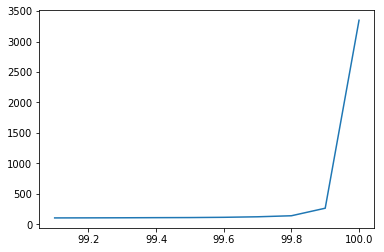

In [31]:
plt.plot(i,threshold_values)

### We can see that at 99.9 percentile we have a sudden change from 263 to 3350
### so our threshold value should be 263.9265

In [32]:
A = percentage_change_vector.tolist()
# 99.9 percentile index in A 
value = round(.999 * len(A))
value

30825

In [33]:
df = pd.DataFrame(A,columns=['%change'])
df['Weight_vetor']= w
feature_names = count_vect.get_feature_names()
df['feature'] = feature_names
df = df.sort_values(by = ['%change']).reset_index(drop=True)
df[:10]

,%change,Weight_vetor,feature
0,0.5,0.000132,wuit
1,0.6,0.000132,jetta
2,0.6,0.000132,candia
3,1.3,0.000137,mues
4,1.7,0.000261,brocc
5,2.0,0.000066,dissap
6,2.0,0.000127,baggguett
7,2.1,0.000066,recenti
8,2.1,-0.002023,unediblechip
9,2.2,0.000066,ashy


### features those value are more than threshold

In [34]:
#features more than threshold
df['feature'][30825:]

30825           quacamol
30826             squidi
30827             suddon
30828               dent
30829            shaddix
30830             cinema
30831               whys
30832                cgi
30833            caustic
30834               clue
30835         vegetarian
30836               prom
30837             faulti
30838           themthes
30839             retent
30840               denk
30841    onlinecandyshop
30842             yellow
30843              maker
30844              parti
30845              noodl
30846                cup
30847              cooki
30848               taxi
30849               aram
30850             hazard
30851           sweedish
30852            subsist
30853            inspect
30854           marzapan
30855             imagin
Name: feature, dtype: object

### Check sparsity on weight wector obtained by L1 regularizer

In [35]:
lr_model = LogisticRegression(C=.01, penalty = 'l1')
lr_model.fit(x_train_bow,y_train)
print(np.count_nonzero(lr_model.coef_))

13


In [36]:
lr_model = LogisticRegression(C=1, penalty = 'l1')
lr_model.fit(x_train_bow,y_train)
print(np.count_nonzero(lr_model.coef_))

1055


In [37]:
lr_model = LogisticRegression(C=10, penalty = 'l1')
lr_model.fit(x_train_bow,y_train)
print(np.count_nonzero(lr_model.coef_))

5268


In [38]:
lr_model = LogisticRegression(C=100, penalty = 'l1')
lr_model.fit(x_train_bow,y_train)
print(np.count_nonzero(lr_model.coef_))

10483


## TF-IDF

In [39]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
x_train_tfidf = tf_idf_vect.fit_transform(x_train)
x_train_tfidf = preprocessing.normalize(x_train_tfidf)
x_test_tfidf = tf_idf_vect.transform(x_test)
print(x_train_tfidf.shape)
print(x_test_tfidf.shape)

(67000, 38973)
(33000, 38973)


Best tunned parameter is {'C': 10}
Train data accuracy is 94.446194% 


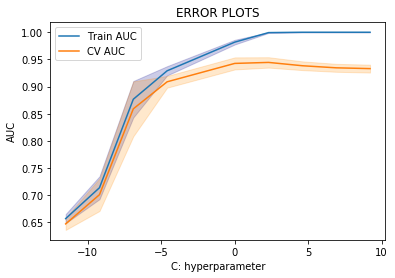

In [40]:
c=optimal_val(x=x_train_tfidf,y=y_train)

###  Testing C on test data usin l1 regularizer

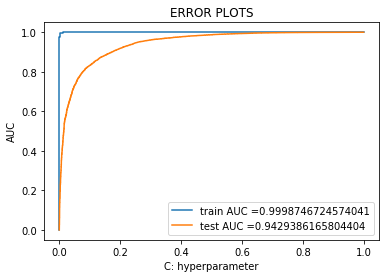

In [41]:
from sklearn.metrics import roc_curve, auc
lr_model_l1 = LogisticRegression(C=c['C'] , penalty = 'l1')
lr_model_l1.fit(x_train_tfidf,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_model_l1.predict_proba(x_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_model_l1.predict_proba(x_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Testing C in test data using L2 regularizer

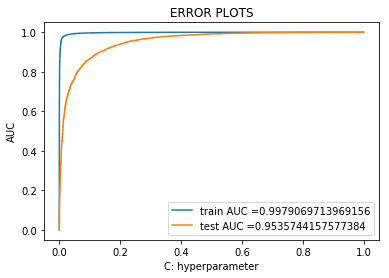

In [42]:
from sklearn.metrics import roc_curve, auc
lr_model_l2 = LogisticRegression(C=c['C'] , penalty = 'l2')
lr_model_l2.fit(x_train_tfidf,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_model_l2.predict_proba(x_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_model_l2.predict_proba(x_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix on Train Data

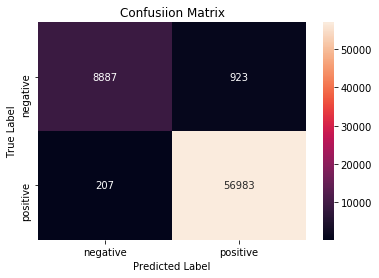

In [43]:
# predict the response
y_pred_tfidf = lr_model_l2.predict(x_train_tfidf)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_tfidf)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [44]:
print(classification_report(y_train ,y_pred_tfidf))

             precision    recall  f1-score   support

          0       0.98      0.91      0.94      9810
          1       0.98      1.00      0.99     57190

avg / total       0.98      0.98      0.98     67000



### Confusion Matrix on Test Data

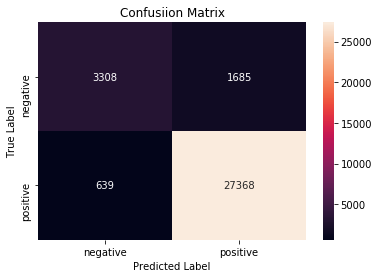

In [45]:
# predict the response
y_pred_tfidf = lr_model_l2.predict(x_test_tfidf)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_tfidf)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [46]:
print(classification_report(y_test ,y_pred_tfidf))

             precision    recall  f1-score   support

          0       0.84      0.66      0.74      4993
          1       0.94      0.98      0.96     28007

avg / total       0.93      0.93      0.93     33000



###  Top 10 Positive and Negative values using TF-IDF Vectorizer

In [56]:
def important_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\tNegative\t\t\t\t\tPositive")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
important_features(tf_idf_vect,lr_model_l2)

		Negative					Positive
	-14.5582	disappoint     				16.4828	great          
	-13.8085	worst          				14.7967	delici         
	-11.8581	aw             				14.3959	best           
	-10.3413	two star       				13.9383	love           
	-10.2342	unfortun       				13.1340	perfect        
	-9.9502	terribl        				11.0469	high recommend 
	-9.7915	wors           				10.4355	excel          
	-9.5591	horribl        				9.9802	wont disappoint
	-9.4314	bland          				9.8948	addict         
	-8.4844	threw          				9.5207	amaz           


### Pertubation test on Tf-idf

In [48]:
#Weights before adding random noise
w = lr_model_l2.coef_[0]
# adding small value to eliminate zero by division error
w = w + .000001
print(w[:30])

[-1.29494125  0.38302688  0.19186897  0.06812155  0.80823107  4.14693249
  0.47789811  0.96253735 -0.73443632  1.05699347 -0.31672843 -1.64994181
 -0.0298934   0.68850003 -1.68679183  0.4825188  -0.73401159  2.3096527
  0.20549256  0.58729711 -1.24576129  0.01829203  0.71185484  0.736024
 -0.70724097  1.15349085  1.06027365 -0.25962888 -0.34209338 -0.01412444]


In [49]:
#adding random noise to train data
from scipy.sparse import find
import copy
x_train_per = copy.deepcopy(x_train_tfidf)
noise = np.random.uniform(low=-0.0001, high=0.0001,size=(find(x_train_per)[0].size))

i,j,v = find(x_train_per)
x_train_per[i,j] = noise + x_train_per[i,j]

In [50]:
#fitting model on new data set
lr_model_per = LogisticRegression(C=.01, penalty = 'l2')
lr_model_per.fit(x_train_per,y_train)
w1 = lr_model_per.coef_[0]
w1 = w1 + .000001
print(w1[:30])

[-0.0027227   0.00082261 -0.004676    0.00236255  0.09390163  0.03665564
 -0.00318689  0.00274747  0.00093545  0.004904    0.05345393 -0.00943893
  0.01839547  0.00431798  0.00099972  0.00457349  0.00258492  0.023873
 -0.00058818  0.00218829  0.01355275  0.00096816  0.00305263  0.00402138
 -0.00340546 -0.00092389  0.0041084  -0.00080598 -0.009205    0.0029653 ]


In [51]:
percentage_change_vector  = np.round((abs((w-w1)/w)*100),1)
print(percentage_change_vector)

[ 99.8  99.8 102.4 ...  99.5 100.8  99.3]


In [52]:
i=np.arange(99.1,100,.1)
threshold_values=np.percentile(percentage_change_vector,i)
threshold_values

array([  115.9       ,   118.3448    ,   121.4196    ,   125.7168    ,
         130.728     ,   140.2112    ,   158.5168    ,   195.3232    ,
         319.7868    , 12692.79999991])

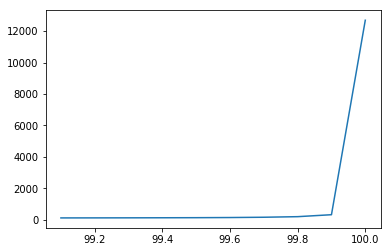

In [53]:
plt.plot(i,threshold_values)

### We can see that at 99.9 percentile we have a sudden change from 319 to 12692
### so our threshold value should be 319.7868

In [54]:
A = percentage_change_vector.tolist()
# 99.9 percentile index in A 
value = round(.999 * len(A))
value

38934

In [57]:
df = pd.DataFrame(A,columns=['%change'])
df['Weight_vetor']= w
feature_names = tf_idf_vect.get_feature_names()
df['feature'] = feature_names
df = df.sort_values(by = ['%change']).reset_index(drop=True)
df[:10]

,%change,Weight_vetor,feature
0,1.1,-0.035293,rid
1,1.9,0.007812,school snack
2,2.7,-0.003225,male cat
3,3.8,0.001866,pasta made
4,3.9,-0.173535,never
5,5.3,0.001259,one home
6,5.4,0.004357,got lot
7,7.2,0.002875,diseas love
8,8.9,0.001455,grew drink
9,9.7,-0.018976,metal


### features those value are more than threshold

In [58]:
#features more than threshold
df['feature'][38934:]

38934          though give
38935          good digest
38936             see much
38937          year famili
38938                 yard
38939            three bag
38940             dog sick
38941                 said
38942                slide
38943              granola
38944            com alway
38945           throw away
38946                 bean
38947           dont smell
38948         without feel
38949            mint tast
38950               chines
38951          flavor hope
38952              ive one
38953          avail store
38954                 latt
38955            like open
38956         find cheaper
38957                 care
38958              italian
38959               target
38960          great drink
38961               enough
38962            like your
38963                drawn
38964          sweet great
38965            brand one
38966    disappoint amazon
38967                 taco
38968          purchas bag
38969                 week
38970           ive search
3

## Avg W2V

### Creating W2V for train data

In [64]:
#function for creating avg word2vector
from gensim.models import Word2Vec

list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

x_train_avgw2v = np.array(sent_vectors)

### Using Train Model to vectorize Test data

In [65]:
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

x_test_avgw2v = np.array(sent_vectors)

(67000, 50)
(33000, 50)
Best tunned parameter is {'C': 1}
Train data accuracy is 90.101221% 


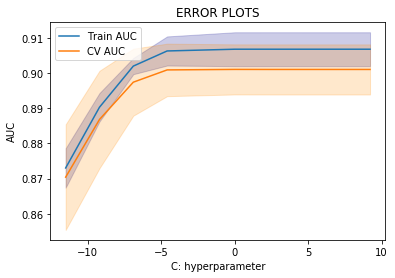

In [70]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
x_train_avgw2v_stand = scale.fit_transform(x_train_avgw2v)
x_test_avgw2v_stand = scale.transform(x_test_avgw2v)
print(x_train_avgw2v_stand.shape)
print(x_test_avgw2v_stand.shape)

#getting c value
c = optimal_val(x=x_train_avgw2v_stand,y=y_train)

### Testing C on test data using L1 regularizer

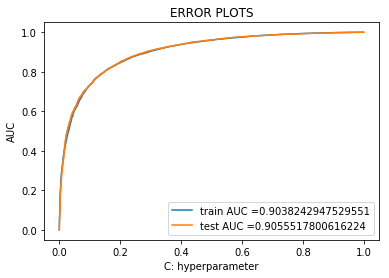

In [72]:
from sklearn.metrics import roc_curve, auc
lr_model_l1 = LogisticRegression(C=c['C'] , penalty = 'l1')
lr_model_l1.fit(x_train_avgw2v_stand,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_model_l1.predict_proba(x_train_avgw2v_stand)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_model_l1.predict_proba(x_test_avgw2v_stand)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Testing C on test data using L2 regularizer

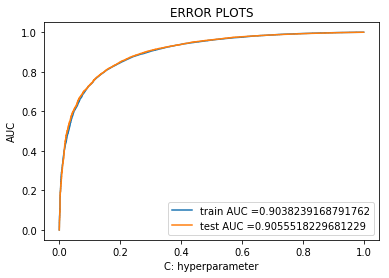

In [74]:
from sklearn.metrics import roc_curve, auc
lr_model_l2 = LogisticRegression(C=c['C'] , penalty = 'l2')
lr_model_l2.fit(x_train_avgw2v_stand,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_model_l2.predict_proba(x_train_avgw2v_stand)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_model_l2.predict_proba(x_test_avgw2v_stand)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix using train data

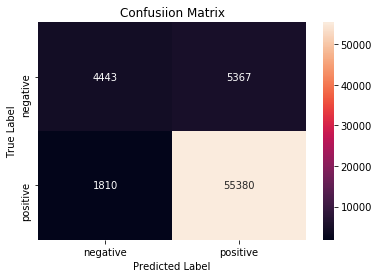

In [87]:
# predict the response
y_pred_w2v = lr_model_l2.predict(x_train_avgw2v_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_w2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [88]:
print(classification_report(y_train ,y_pred_w2v))

             precision    recall  f1-score   support

          0       0.71      0.45      0.55      9810
          1       0.91      0.97      0.94     57190

avg / total       0.88      0.89      0.88     67000



### Confusion Matrix for test data

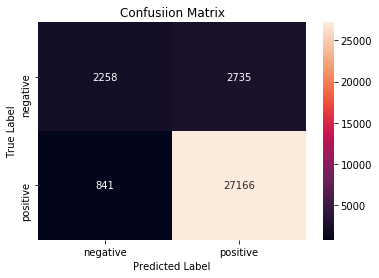

In [89]:
# predict the response
y_pred_w2v = lr_model_l2.predict(x_test_avgw2v_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_w2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [90]:
print(classification_report(y_test ,y_pred_w2v))

             precision    recall  f1-score   support

          0       0.73      0.45      0.56      4993
          1       0.91      0.97      0.94     28007

avg / total       0.88      0.89      0.88     33000



## TF-IDF Weighted W2V

### Creating a tf-idf weighted w2v for train data

In [91]:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
def weighted_word_vector(model,x):
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    list_of_sentance=[]
    for sentance in x:
        list_of_sentance.append(sentance.split())
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in list_of_sentance: # for ea1ch review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

model = TfidfVectorizer()
model.fit_transform(x_train)
x_train_weighted = weighted_word_vector(model,x_train)

### Using the train model on test data

In [92]:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
def weighted_word_vector(model,x):
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    list_of_sentance=[]
    for sentance in x:
        list_of_sentance.append(sentance.split())
    
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in list_of_sentance: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

x_test_weighted = weighted_word_vector(model,x_test)

(67000, 50)
(33000, 50)
Best tunned parameter is {'C': 1}
Train data accuracy is 87.434179% 


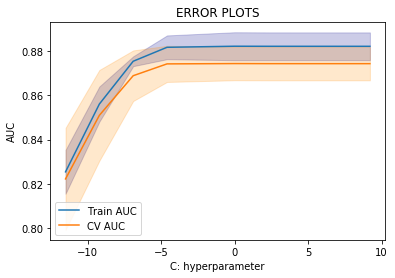

In [93]:
x_train_weighted_stand = scale.fit_transform(x_train_weighted)
x_test_weighted_stand = scale.fit_transform(x_test_weighted)
print(x_train_weighted_stand.shape)
print(x_test_weighted_stand.shape)

#getting C value
c = optimal_val(x=x_train_weighted_stand,y=y_train)

### Testing C on test data using L1 regularizer

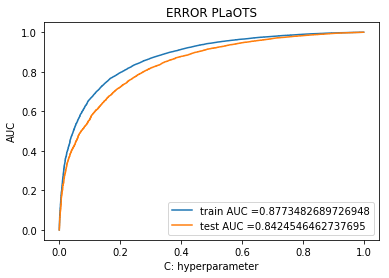

In [94]:
from sklearn.metrics import roc_curve, auc
lr_model_l1 = LogisticRegression(C=c['C'] , penalty = 'l1')
lr_model_l1.fit(x_train_weighted_stand,y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_model_l1.predict_proba(x_train_weighted_stand)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_model_l1.predict_proba(x_test_weighted_stand)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLaOTS")
plt.show()

### Testing C on test data using L2 regularizer

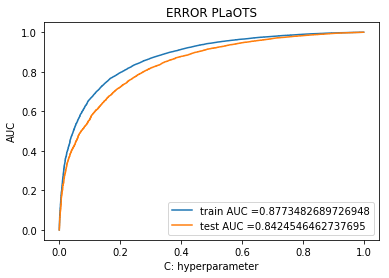

In [95]:
from sklearn.metrics import roc_curve, auc
lr_model_l2 = LogisticRegression(C=c['C'] , penalty = 'l2')
lr_model_l2.fit(x_train_weighted_stand,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_model_l1.predict_proba(x_train_weighted_stand)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_model_l1.predict_proba(x_test_weighted_stand)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLaOTS")
plt.show()

### Confusion Matrix For Train data

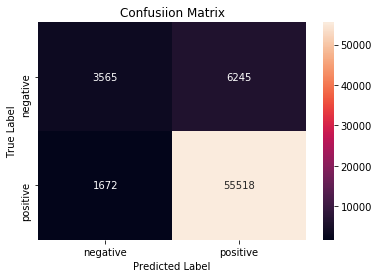

In [96]:
# predict the response
y_pred_tfidfw2v = lr_model_l2.predict(x_train_weighted_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_tfidfw2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [97]:
print(classification_report(y_train ,y_pred_tfidfw2v))

             precision    recall  f1-score   support

          0       0.68      0.36      0.47      9810
          1       0.90      0.97      0.93     57190

avg / total       0.87      0.88      0.87     67000



### Confusion Matrix For Train data

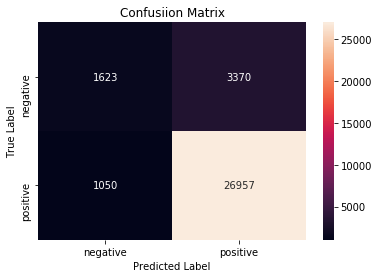

In [98]:
# predict the response
y_pred_tfidfw2v = lr_model_l2.predict(x_test_weighted_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_tfidfw2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [99]:
print(classification_report(y_test ,y_pred_tfidfw2v))

             precision    recall  f1-score   support

          0       0.61      0.33      0.42      4993
          1       0.89      0.96      0.92     28007

avg / total       0.85      0.87      0.85     33000



## Conclusion

In [100]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer ", "Model", "Hyper Parameter/C", "AUC"]
x.add_row(["BOW", "LogisticRegression", 10 , .93])
x.add_row(["TF-IDF", "LogisticRegression", 10  , .95])
x.add_row(["AVG W2V", "LogisticRegression", 1  , .90])
x.add_row(["TF-IDF Weighted W2V", "LogisticRegression", 1  , .84])
print(x)

+---------------------+--------------------+-------------------+------+
|     Vectorizer      |       Model        | Hyper Parameter/C | AUC  |
+---------------------+--------------------+-------------------+------+
|         BOW         | LogisticRegression |         10        | 0.93 |
|        TF-IDF       | LogisticRegression |         10        | 0.95 |
|       AVG W2V       | LogisticRegression |         1         | 0.9  |
| TF-IDF Weighted W2V | LogisticRegression |         1         | 0.84 |
+---------------------+--------------------+-------------------+------+


 ## Observation

## BOW
- While applying additive smoothing the optimal C value for BOW is 10
- From the ROC curve we can see that using 1/lambda = 10 the AUC achieved for test data is 93%
- The f1-score for both train and test data comes approx 93% which proves that alpha = 10 is the
  best parameter for additive       smoothing
- worst,aw,wors,terribl,tasteless,threw,disappoint,bland,cancel,unfortun are top negative words
- uniqu,delici,awesom,addict,amaz,perfect,best,yummi,excel,skeptic are top positive words

## TF-IDF
- While applying additive smoothing the optimal alpha value for TF-IDF is 10
- From the ROC curve we can see that AUC of test in TF-IDF vectorizer is more than any other 
  vectorizer technique used
- disappoint,worst,aw,two star,unfortun,terribl,wors,horribl,bland,threw are top negative words
- great,delici,best,love,perfect,high recommend,excel,wont disappoint,addict,amaz are top positive words

## W2V and Tf-Idf weighted W2V
- Best C achieved is 10
- AUC for these vectorizers decreased in comparision to above .90 and .84 respectively

-----------------------------------------------------------------------------------------------------------

- Pertubation test applied on both BOW and Tf-Idf shows a sudden change in %change values
  between the normal Weight vector and added noise vector at 99%
- After viewing the components having the percentage value less than that % change value. 
  We can clearly see the components are multicollinear
  